In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import session_info
import matplotlib.pyplot as plt

import os

In [2]:
session_info.show()

# Download

## Read in path file

In [3]:
samplefile = pd.read_csv('/nfs/team205/heart/mapped/CMO/csv/multiome-foetal_20221221.csv')
samplefile.set_index('CMO_ID',inplace=True)
samplefile

,Multiome_ID,Mapping_iRODS
CMO_ID,,
7089STDY13216916,7089STDY13216920_BHF_F_Hea13242527,/seq/illumina/runs/46/46301/cellranger/cellran...
7089STDY13216917,7089STDY13216921_BHF_F_Hea13242528,/seq/illumina/runs/46/46301/cellranger/cellran...
7089STDY13216918,7089STDY13216922_BHF_F_Hea13242529,/seq/illumina/runs/46/46301/cellranger/cellran...
7089STDY13216919,7089STDY13216923_BHF_F_Hea13242530,/seq/illumina/runs/46/46301/cellranger/cellran...


## Download from iRODs

In [ ]:
cd /nfs/team205/heart/mapped/CMO
sed 1d ./csv/multiome-foetal_20221221.csv | while IFS=, read -r mID cID IRODSPATH
do
echo $cID

# create output folder if it does not exist
if [[ ! -d "$cID" ]]; then
    mkdir -p "$cID"
fi

iget -K -r $IRODSPATH/raw_feature_bc_matrix $cID
iget -K $IRODSPATH/web_summary.html ./websummary/multiome-foetal_20221221/${cID}_web_summary.html
done

In [ ]:
cID=7089STDY13216919
IRODSPATH=/seq/illumina/runs/46/46301/cellranger/cellranger700_count_46301_7089STDY13216919_GRCh38-2020-A
iget -K -r $IRODSPATH/raw_feature_bc_matrix $cID
iget -K $IRODSPATH/web_summary.html ./websummary/multiome-foetal_20221221/${cID}_web_summary.html

# Read in Multiome data

In [4]:
# post-cellbender
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/QC/multiome_RNA_foetal_prefilter.h5ad',
                     backed = 'r')
# only multiplexed data
adata = adata[adata.obs['combinedID'].isin(list(samplefile['Multiome_ID']))]

adata

View of AnnData object with n_obs × n_vars = 74984 × 36601 backed at '/nfs/team205/heart/anndata_objects/Foetal/QC/multiome_RNA_foetal_prefilter.h5ad'
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-17', 'ambient_expression-18', 'ambient_expression-19', 'ambient_expression-2', 'ambient_expression-20', 'ambient_expression-21', 'ambient_expression-22', 'ambient_expression-23', 'ambient_expression-24', 'ambient_expression-25', 'ambient_

In [5]:
adata.obs['combinedID'].value_counts()

7089STDY13216920_BHF_F_Hea13242527    27498
7089STDY13216921_BHF_F_Hea13242528    24211
7089STDY13216922_BHF_F_Hea13242529    21402
7089STDY13216923_BHF_F_Hea13242530     1873
Name: combinedID, dtype: int64

# CMO result

In [ ]:
* donor_assignment: Determining by selecting which of its donors (tags) has the maximum count per cell
* ratio: Ratio of "the 1st maximum tag count" to "the 2nd maximum tag count" per cell.

In [11]:
# function to calculate proportion of the maximum tag count to the total tag count

def ratio(row):
    # convert to array
    arr = np.array(row)
    # sort -> reverse to make it descending
    arr.sort()
    arr = arr[::-1]
    # get 1st and 2nd max value
    first = arr[0]
    second = arr[1]
    # return ratio
    return first/second

In [12]:
for i,cmo_ID in enumerate(samplefile.index):
    # read in
    cmo = sc.read_10x_mtx(f'/nfs/team205/heart/mapped/CMO/{cmo_ID}/raw_feature_bc_matrix',
                     gex_only=False)
    
    # get multiome ID
    multi_ID = samplefile.loc[cmo_ID,'Multiome_ID']

    # modify obs_names
    cmo.obs_names = multi_ID + '_' + cmo.obs_names
    # add sample IDs
    cmo.obs['combinedID'] = multi_ID
    
    # select cells in post-cellbender adata
    obsnames = adata.obs.index[adata.obs['combinedID']==multi_ID]
    cmo = cmo[obsnames]
    # get obs
    cmo_obs = cmo.obs.copy()
    
    # prepare count dataframe
    X_df = cmo.to_df()
    X_df.columns = [x.split('-')[0] for x in X_df.columns]
    
    # calculate delta
    cmo_obs['ratio'] = X_df.apply(ratio,axis=1)
    cmo_obs['top_count'] = X_df.max(axis=1)
    
    # assign donor
    def which_is_max(row):
        # convert to array
        arr = np.array(row)
        # get position
        pos = np.where(arr == np.max(arr))[0]
        # get donor
        don = ','.join(X_df.columns[pos])
        return don
    def n_max_donor(row):
        # convert to array
        arr = np.array(row)
        # get position
        pos = np.where(arr == np.max(arr))[0]
        return len(pos)
    cmo_obs['donor_assignment'] = X_df.apply(which_is_max,axis=1)
    cmo_obs['n_donor_assigned'] = X_df.apply(n_max_donor,axis=1)
    
    # add count values
    cmo_obs[X_df.columns] = X_df.copy()
    
    # concatenate
    if i==0:
        cmo_obs_all = cmo_obs.copy()
    else:
        cmo_obs_all = pd.concat([cmo_obs_all,cmo_obs])
        
    del cmo, cmo_obs, multi_ID, obsnames, X_df

print(cmo_obs_all.shape)
cmo_obs_all.head()

(74984, 8)


,combinedID,ratio,top_count,donor_assignment,n_donor_assigned,Hst40,Hst39,Hst36
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1,7089STDY13216920_BHF_F_Hea13242527,3.461564,125274.0,Hst40,1,125274.0,36190.0,NaN
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1,7089STDY13216920_BHF_F_Hea13242527,3.092936,88226.0,Hst39,1,28525.0,88226.0,NaN
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1,7089STDY13216920_BHF_F_Hea13242527,2.425848,64382.0,Hst39,1,26540.0,64382.0,NaN
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1,7089STDY13216920_BHF_F_Hea13242527,3.163533,115915.0,Hst40,1,115915.0,36641.0,NaN
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1,7089STDY13216920_BHF_F_Hea13242527,1.360772,51478.0,Hst40,1,51478.0,37830.0,NaN


In [13]:
# check samples which is 1st max == 2d max
cmo_obs_all[cmo_obs_all['n_donor_assigned']==2]

,combinedID,ratio,top_count,donor_assignment,n_donor_assigned,Hst40,Hst39,Hst36
7089STDY13216920_BHF_F_Hea13242527_CAGGCTATCTACCTGC-1,7089STDY13216920_BHF_F_Hea13242527,1.0,3215.0,"Hst40,Hst39",2,3215.0,3215.0,NaN
7089STDY13216920_BHF_F_Hea13242527_GATTTGCAGCTCCTTA-1,7089STDY13216920_BHF_F_Hea13242527,1.0,3127.0,"Hst40,Hst39",2,3127.0,3127.0,NaN
7089STDY13216920_BHF_F_Hea13242527_TCGTTACGTACTTAGG-1,7089STDY13216920_BHF_F_Hea13242527,1.0,2827.0,"Hst40,Hst39",2,2827.0,2827.0,NaN
7089STDY13216920_BHF_F_Hea13242527_ACCCGGTAGTCACGAT-1,7089STDY13216920_BHF_F_Hea13242527,1.0,1378.0,"Hst40,Hst39",2,1378.0,1378.0,NaN
7089STDY13216920_BHF_F_Hea13242527_ATAATGGCAACCTAAT-1,7089STDY13216920_BHF_F_Hea13242527,1.0,2992.0,"Hst40,Hst39",2,2992.0,2992.0,NaN
7089STDY13216920_BHF_F_Hea13242527_GTAGCGCTCCTTCGTA-1,7089STDY13216920_BHF_F_Hea13242527,1.0,1943.0,"Hst40,Hst39",2,1943.0,1943.0,NaN
7089STDY13216920_BHF_F_Hea13242527_TACCGTTGTATTGTGG-1,7089STDY13216920_BHF_F_Hea13242527,1.0,2800.0,"Hst40,Hst39",2,2800.0,2800.0,NaN
7089STDY13216920_BHF_F_Hea13242527_TGCATGAGTTCGGGAT-1,7089STDY13216920_BHF_F_Hea13242527,1.0,2270.0,"Hst40,Hst39",2,2270.0,2270.0,NaN
7089STDY13216921_BHF_F_Hea13242528_GATCGATTCCTAGTCC-1,7089STDY13216921_BHF_F_Hea13242528,1.0,3742.0,"Hst40,Hst39",2,3742.0,3742.0,NaN
7089STDY13216921_BHF_F_Hea13242528_CTTATGTTCGGTTACG-1,7089STDY13216921_BHF_F_Hea13242528,1.0,3958.0,"Hst40,Hst39",2,3958.0,3958.0,NaN


# Save

In [14]:
cmo_obs_all.to_csv('/nfs/team205/heart/mapped/CMO/result_summary/CMO-result_multiome-foetal_20230207.csv')

# Proportions

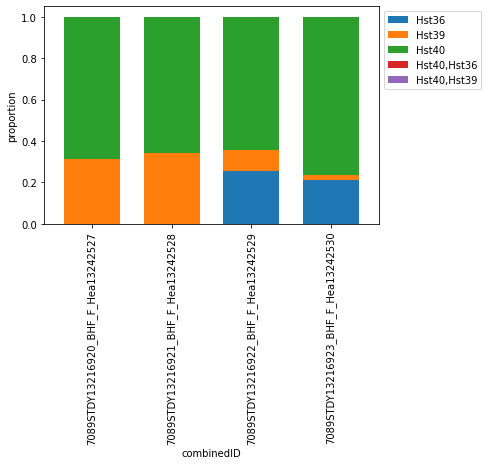

##### 7089STDY13216920_BHF_F_Hea13242527 #####
Hst40          18933
Hst39           8557
Hst40,Hst39        8
Name: donor_assignment, dtype: int64

##### 7089STDY13216921_BHF_F_Hea13242528 #####
Hst40          15866
Hst39           8335
Hst40,Hst39       10
Name: donor_assignment, dtype: int64

##### 7089STDY13216922_BHF_F_Hea13242529 #####
Hst40          13755
Hst36           5466
Hst39           2178
Hst40,Hst36        2
Hst40,Hst39        1
Name: donor_assignment, dtype: int64

##### 7089STDY13216923_BHF_F_Hea13242530 #####
Hst40    1435
Hst36     394
Hst39      44
Name: donor_assignment, dtype: int64



In [10]:
df = cmo_obs_all.copy()
plt.rcParams['figure.figsize'] = 3,3
tmp = pd.crosstab(df['combinedID'], df['donor_assignment'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.7)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()
plt.show()

for sam in list(samplefile['Multiome_ID']):
    df_s = df[df['combinedID']==sam]
    print(f'##### {sam} #####')
    print(df_s['donor_assignment'].value_counts())
    print('')